# Initial Value Problems

An *initial value problem* (IVP) can be written as:

$$
\begin{align*}
y'(t) &= f(t,y(t)), \quad t\ge t_0 \\
y(t_0) &= y_0
\end{align*}
$$

for some *right-hand side function* $f(t,y)$ and *initial condition* $y_0$ for $t=t_0$. In these problems, the independent variable $t$ often represents time.

Sometimes basic calculus can be used to solve these equations. For example, some *linear* and *separable* equations have closed-form solutions. But in general we have to resort to *numerical methods* to find approximations to the solution $y(t)$.

In [1]:
using PyPlot, PyCall

## Euler's method

The most basic approach for numerically solving an IVP is *Euler's method*, illustrated below.

![Euler_method](euler_method.png "Euler's method")
(from Wikipedia, <https://en.wikipedia.org/wiki/Euler_method>).

We first choose a *step size*, or *time step*, $h$, and define the discrete times $t_n = t_0 + nh$, $n = 0,1,\ldots$. Euler's method advances the solution $y_n$ at time $t_n$ to time $t_{n+1}$ by a linear approximation using the derivative at time $t_n$:

$$
y_{n+1} = y_n + hf(t_n,y_n)
$$

With some assumptions on the IVP and the step size, these values can be shown to be good approximation to the true solution, that is, $y_n \approx y(t_n$).

While described for scalar-valued functions $y(t)$, the method works equally well for systems of equations, that is, when $y(t)$ and $f(t,y(t))$ are vector-valued.

## Euler's method, implementation

We implement a general version of Euler's method which takes the right-hand side function $f(t,y(t))$
as an argument. In addition, it takes the initial condition $y_0$, the step size $h$, the number of steps $N$, and the starting time $t_0$ which has a default value of $0$. Note that the implementations supports solutions $y$ that are vector-valued, and the output `y` is a 2D array of the approximate solutions at each time step.

In [2]:
function euler(f, y0, h, N, t0=0.0)
    t = t0 .+ h*(0:N)
    y = zeros(N+1, length(y0))
    
    y[1,:] .= y0
    for n = 1:N
        y[n+1,:] = y[n,:] + h * f(t[n], y[n,:])
    end
    
    return t,y
end

euler (generic function with 2 methods)

We demonstrate the method on a model problem with $f(t,y) = -y + \sin t$ and $y(0) = 1$. We solve using Euler's method with time step $h=0.2$ and $N=20$ steps.

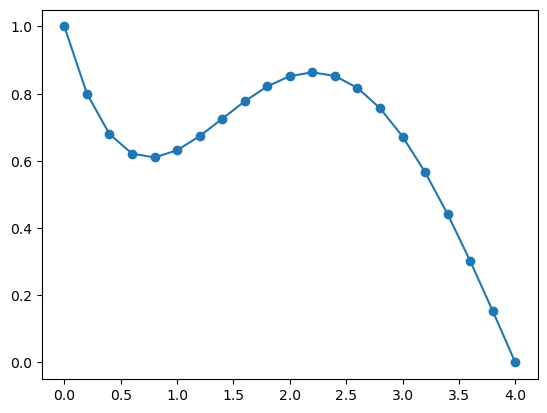

In [3]:
f(t,y) = -y .+ sin(t)
t,y = euler(f, 1, 0.2, 20)
plot(t, y, "-o");

We can compare the results to the exact solution:

$$
y_\mathrm{exact} = e^{-t} + (\sin t - \cos t + e^{-t}) / 2
$$

In the code below, we solve three times using various time steps $h$. In the plot, we see that the results are generally better for smaller $h$ (as expected), and the accuracy seems to roughly scale linearly with $h$. This can be shown to be true in general: the method is *convergent* (the approximations approach the exact solution as $h \rightarrow 0$), and the method is first-order accurate (the error scales with the first power of $h$).

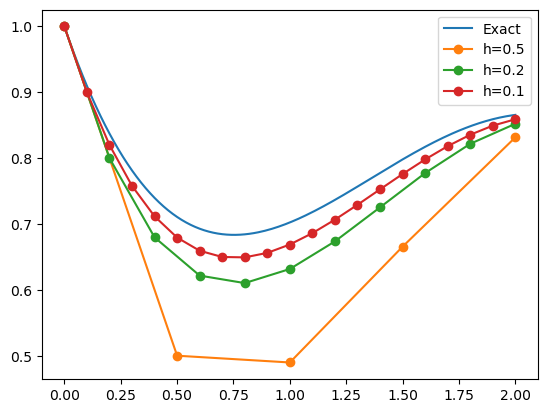

In [4]:
yexact(t) = exp(-t) + (sin(t) - cos(t) + exp(-t)) / 2
tt = 0:0.01:2
plot(tt, yexact.(tt))
for h = [0.5, 0.2, 0.1]
    t,y = euler(f, 1, h, round(Int, 2/h))
    plot(t, y, "-o")
end
legend(("Exact", "h=0.5", "h=0.2", "h=0.1"));

## The Runge-Kutta method

While Euler's method does give accurate results for small enough time steps $h$, its first-order convergence is often considered too slow and much better methods have been developed. One of the most popular methods is the following 4th order accurate Runge-Kutta method (RK4):

$$
\begin{align*}
k_1 &= h f(t_n, y_n) \\
k_2 &= h f(t_n + h/2, y_n + k_1/2) \\
k_3 &= h f(t_n + h/2, y_n + k_2/2) \\
k_4 &= h f(t_n + h, y_n + k_3) \\
y_{n+1} &= y_n + (k_1 + 2k_2 + 2k_3 + k_4) / 6
\end{align*}
$$

We implement it in a very similar way to before. Note that each step now requires computing the four so-called *stages* or *stage derivatives* $k_1,k_2,k_3,k_4$.

In [5]:
function rk4(f, y0, h, N, t0=0)
    t = t0 .+ h*(0:N)
    y = zeros(N+1, length(y0))
    
    y[1,:] .= y0
    for n = 1:N
        k1 = h * f(t[n], y[n,:])
        k2 = h * f(t[n] + h/2, y[n,:] + k1/2)
        k3 = h * f(t[n] + h/2, y[n,:] + k2/2)
        k4 = h * f(t[n] + h, y[n,:] + k3)
        y[n+1,:] = y[n,:] + (k1 + 2k2 + 2k3 + k4) / 6
    end
    
    return t,y
end

rk4 (generic function with 2 methods)

Run the same test problem as before using RK4:

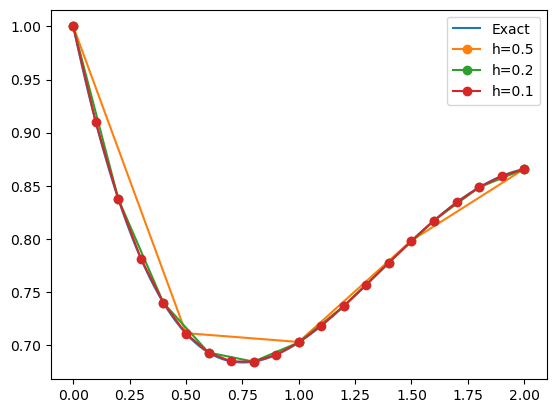

In [6]:
yexact(t) = exp(-t) + (sin(t) - cos(t) + exp(-t)) / 2
tt = 0:0.01:2
plot(tt, yexact.(tt))
for h = [0.5, 0.2, 0.1]
    t,y = rk4(f, 1, h, round(Int, 2/h))
    plot(t, y, "-o")
end
legend(("Exact", "h=0.5", "h=0.2", "h=0.1"));

We can see that the results are fundamentally more accurate. In fact, even with largest time step $h=0.5$, the point values are essentially right on top of the exact solution. We can compute the error for the smallest time step $h=0.1$, and note that it has 6 accurate digits:

In [7]:
errors = @. y - yexact(t)
max_error = maximum(abs.(errors))

5.015261516083669e-7